In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# Train using GPU. If not available on your machine, use google colab. 
import pandas as pd;
from scipy.stats import zscore
import torch as torch;
import numpy as np
import torchvision.datasets as datasets
from torchvision import transforms
import torch.nn as nn;
import torch.nn.functional as F;
np.random.seed(42)
#train on GPU if available. It will take a long time to train if done on CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#read in the dataset
num_classes=10;
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, 
                             transform=transform )
full_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True,
                             transform=transform )
batch_size=64;
trainloader = torch.utils.data.DataLoader(full_train_dataset, 
batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(full_test_dataset, 
batch_size=batch_size,shuffle=False)
# create a neural network (inherit from nn.Module)
class ConvNetWithBatchNorm(nn.Module):
    # architecture of the network is specified in the constructor
    def __init__(self): 
        super(ConvNetWithBatchNorm, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),         
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3),
            nn.BatchNorm2d(num_features=12)           
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)   
        )
        self.classifier = nn.Sequential(
            nn.Linear(12*6*6, 50),         
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(50,num_classes)            
        )
        
    # here we specify the computation (forward phase of training) how "x" is transfered into output "y"
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x)
    # constructor and forward() - that is all we need, the rest is implemented in the nn.Module and we inherit it
# create an instance of the network
model=ConvNetWithBatchNorm().to(device);
criterion = F.nll_loss;
# this optimizer will do gradient descent for us
# experiment with learning rate and optimizer type
learning_rate = 0.001;
# note that we have to add all weights&biases, for both layers, to the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
# we add a learning rate scheduler, which will modify the learning rate during training
# will initially start low, then increase it ("warm up"), and then gradually descrease it
n_epochs = 30;
num_updates = n_epochs*int(np.ceil(len(trainloader.dataset)/batch_size))
print(num_updates)
warmup_steps=1000;
def warmup_linear(x):
    if x < warmup_steps:
        lr=x/warmup_steps
    else:
        lr=max( (num_updates - x ) / (num_updates - warmup_steps), 0.)
    return lr;
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_linear);
for i in range(n_epochs):
    for j, data in enumerate(trainloader):
      
        inputs, labels = data        
        inputs=inputs.to(device);
        labels=labels.to(device);
        
        optimizer.zero_grad();
        #forward phase - predictions by the model
        outputs = model(inputs);
        #forward phase - risk/loss for the predictions
        risk = criterion(outputs, labels);
  
        # calculate gradients
        risk.backward();
        
        # take the gradient step
        optimizer.step();
        scheduler.step();
        
        batch_risk=risk.item();
    with (torch.no_grad()):
      correct = 0;
      for j, data in enumerate(testloader):
        
          inputs, labels = data        
          inputs=inputs.to(device);
          labels=labels.to(device);
          outputs = model(inputs);
          pred = outputs.data.max(dim=1, keepdim=True)[1]
          correct += pred.eq(labels.data.view_as(pred)).sum().item();
          
    print(i, batch_risk, correct / len(testloader.dataset))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
23460


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0 1.6632930040359497 0.4369
1 1.8011674880981445 0.5027
2 1.1353694200515747 0.5224
3 0.8839263319969177 0.5476
4 1.250756859779358 0.562
5 1.5115619897842407 0.5726
6 0.8475539684295654 0.5728
7 0.7453178763389587 0.5822
8 1.3494120836257935 0.5959
9 1.0869866609573364 0.5933
10 1.1514432430267334 0.5979
11 1.1242903470993042 0.5952
12 1.0936717987060547 0.6039
13 1.1802644729614258 0.6108
14 0.9933774471282959 0.6054
15 0.7920123934745789 0.6121
16 0.523009181022644 0.6146
17 0.8321347832679749 0.616
18 0.9582446813583374 0.6116
19 0.8899344801902771 0.614
20 1.440187931060791 0.6169
21 0.8439165949821472 0.6188
22 0.9864885210990906 0.6162
23 0.34797680377960205 0.6208
24 1.3206325769424438 0.6197
25 0.5868478417396545 0.6227
26 0.7750813961029053 0.6233
27 0.9410382509231567 0.6239
28 0.9023637175559998 0.6185
29 0.5876985788345337 0.6282


**Plot of the accuracy during epochs of training**

In [ ]:
#save value of accuracy in list to plot graph:

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn;
import torch.nn.functional as F;
import torch as torch;
from scipy.stats import zscore
import torchvision.datasets as datasets
from torchvision import transforms
num_classes=10;
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs=range(0,30)
accuracy_list=[]
a1=[]
batch_size=64;
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, 
                             transform=transform )
full_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True,
                             transform=transform )
batch_size=64;
trainloader = torch.utils.data.DataLoader(full_train_dataset, 
batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(full_test_dataset, 
batch_size=batch_size,shuffle=False)
class ConvNetWithBatchNorm(nn.Module):
    # architecture of the network is specified in the constructor
    def __init__(self): 
        super(ConvNetWithBatchNorm, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),         
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3),
            nn.BatchNorm2d(num_features=12)           
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)   
        )
        self.classifier = nn.Sequential(
            nn.Linear(12*6*6, 50),         
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(50,num_classes)            
        )
        
    # here we specify the computation (forward phase of training) how "x" is transfered into output "y"
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x)
    # constructor and forward() - that is all we need, the rest is implemented in the nn.Module and we inherit it
# create an instance of the network
model=ConvNetWithBatchNorm().to(device);
criterion = F.nll_loss;
# this optimizer will do gradient descent for us
# experiment with learning rate and optimizer type
learning_rate = 0.001;
# note that we have to add all weights&biases, for both layers, to the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
# we add a learning rate scheduler, which will modify the learning rate during training
# will initially start low, then increase it ("warm up"), and then gradually descrease it
n_epochs = 30;
num_updates = n_epochs*int(np.ceil(len(trainloader.dataset)/batch_size))
print(num_updates)
warmup_steps=1000;
def warmup_linear(x):
    if x < warmup_steps:
        lr=x/warmup_steps
    else:
        lr=max( (num_updates - x ) / (num_updates - warmup_steps), 0.)
    return lr;
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_linear);
for i in range(n_epochs):
    for j, data in enumerate(trainloader):
      
        inputs, labels = data        
        inputs=inputs.to(device);
        labels=labels.to(device);
        
        optimizer.zero_grad();
        #forward phase - predictions by the model
        outputs = model(inputs);
        #forward phase - risk/loss for the predictions
        risk = criterion(outputs, labels);
  
        # calculate gradients
        risk.backward();
        
        # take the gradient step
        optimizer.step();
        scheduler.step();
        
        batch_risk=risk.item();
    with (torch.no_grad()):
      correct = 0;
      for j, data in enumerate(testloader):
        
          inputs, labels = data        
          inputs=inputs.to(device);
          labels=labels.to(device);
          outputs = model(inputs);
          pred = outputs.data.max(dim=1, keepdim=True)[1]
          correct += pred.eq(labels.data.view_as(pred)).sum().item();
    accuracy = correct / len(testloader.dataset)
    a1.append(accuracy)
accuracy_list.append(a1)
          
    

Files already downloaded and verified
Files already downloaded and verified
23460


<ipython-input-3-66e8caf16dc7>:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
dict1={}
dict1["Simple_Network"]=accuracy_list[0]
#print(dict1)

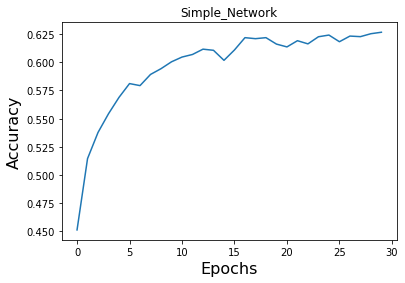

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(epochs,dict1["Simple_Network"])
plt.title('Simple_Network')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()


# **Experimenting with different learning rate, keeping same number of epoch**

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# Train using GPU. If not available on your machine, use google colab. 
import pandas as pd;
from scipy.stats import zscore
import torch as torch;
import numpy as np
import torchvision.datasets as datasets
from torchvision import transforms
import torch.nn as nn;
import torch.nn.functional as F;
np.random.seed(42)
#train on GPU if available. It will take a long time to train if done on CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#read in the dataset
num_classes=10;
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, 
                             transform=transform )
full_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True,
                             transform=transform )
batch_size=64;
trainloader = torch.utils.data.DataLoader(full_train_dataset, 
batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(full_test_dataset, 
batch_size=batch_size,shuffle=False)
# create a neural network (inherit from nn.Module)
class ConvNetWithBatchNorm(nn.Module):
    # architecture of the network is specified in the constructor
    def __init__(self): 
        super(ConvNetWithBatchNorm, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),         
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3),
            nn.BatchNorm2d(num_features=12)           
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)   
        )
        self.classifier = nn.Sequential(
            nn.Linear(12*6*6, 50),         
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(50,num_classes)            
        )
        
    # here we specify the computation (forward phase of training) how "x" is transfered into output "y"
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x)
    # constructor and forward() - that is all we need, the rest is implemented in the nn.Module and we inherit it
# create an instance of the network
model=ConvNetWithBatchNorm().to(device);
criterion = F.nll_loss;
# this optimizer will do gradient descent for us
# experiment with learning rate and optimizer type
learning_rate = 0.0001;
# note that we have to add all weights&biases, for both layers, to the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
# we add a learning rate scheduler, which will modify the learning rate during training
# will initially start low, then increase it ("warm up"), and then gradually descrease it
n_epochs = 30;
num_updates = n_epochs*int(np.ceil(len(trainloader.dataset)/batch_size))
print(num_updates)
warmup_steps=1000;
def warmup_linear(x):
    if x < warmup_steps:
        lr=x/warmup_steps
    else:
        lr=max( (num_updates - x ) / (num_updates - warmup_steps), 0.)
    return lr;
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_linear);
for i in range(n_epochs):
    for j, data in enumerate(trainloader):
      
        inputs, labels = data        
        inputs=inputs.to(device);
        labels=labels.to(device);
        
        optimizer.zero_grad();
        #forward phase - predictions by the model
        outputs = model(inputs);
        #forward phase - risk/loss for the predictions
        risk = criterion(outputs, labels);
  
        # calculate gradients
        risk.backward();
        
        # take the gradient step
        optimizer.step();
        scheduler.step();
        
        batch_risk=risk.item();
    with (torch.no_grad()):
      correct = 0;
      for j, data in enumerate(testloader):
        
          inputs, labels = data        
          inputs=inputs.to(device);
          labels=labels.to(device);
          outputs = model(inputs);
          pred = outputs.data.max(dim=1, keepdim=True)[1]
          correct += pred.eq(labels.data.view_as(pred)).sum().item();
          
    print(i, batch_risk, correct / len(testloader.dataset))

Files already downloaded and verified
Files already downloaded and verified
23460


<ipython-input-6-c772b44ec47b>:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


0 2.01163649559021 0.3101
1 1.645772933959961 0.4087
2 1.3056656122207642 0.445
3 1.3651219606399536 0.4623
4 0.9497140645980835 0.4833
5 1.2678617238998413 0.4904
6 1.2438929080963135 0.5019
7 1.1489384174346924 0.5086
8 1.2047457695007324 0.5133
9 1.1149578094482422 0.5218
10 1.0363249778747559 0.5274
11 0.9563788771629333 0.5294
12 1.5888748168945312 0.5334
13 1.2980492115020752 0.5393
14 0.8553378582000732 0.5393
15 1.820970058441162 0.5476
16 0.9582483172416687 0.5483
17 1.814244270324707 0.5509
18 1.444668173789978 0.5557
19 0.9110224843025208 0.5468
20 1.444419026374817 0.5523
21 1.525260090827942 0.556
22 1.0589969158172607 0.5635
23 1.0464682579040527 0.5597
24 1.564648151397705 0.5572
25 1.0338785648345947 0.5578
26 0.6884133815765381 0.5627
27 0.9485715627670288 0.5601
28 1.8122165203094482 0.5627
29 1.539196252822876 0.559


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# Train using GPU. If not available on your machine, use google colab. 
import pandas as pd;
from scipy.stats import zscore
import torch as torch;
import numpy as np
import torchvision.datasets as datasets
from torchvision import transforms
import torch.nn as nn;
import torch.nn.functional as F;
np.random.seed(42)
#train on GPU if available. It will take a long time to train if done on CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#read in the dataset
num_classes=10;
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, 
                             transform=transform )
full_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True,
                             transform=transform )
batch_size=64;
trainloader = torch.utils.data.DataLoader(full_train_dataset, 
batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(full_test_dataset, 
batch_size=batch_size,shuffle=False)
# create a neural network (inherit from nn.Module)
class ConvNetWithBatchNorm(nn.Module):
    # architecture of the network is specified in the constructor
    def __init__(self): 
        super(ConvNetWithBatchNorm, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),         
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3),
            nn.BatchNorm2d(num_features=12)           
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)   
        )
        self.classifier = nn.Sequential(
            nn.Linear(12*6*6, 50),         
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(50,num_classes)            
        )
        
    # here we specify the computation (forward phase of training) how "x" is transfered into output "y"
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x)
    # constructor and forward() - that is all we need, the rest is implemented in the nn.Module and we inherit it
# create an instance of the network
model=ConvNetWithBatchNorm().to(device);
criterion = F.nll_loss;
# this optimizer will do gradient descent for us
# experiment with learning rate and optimizer type
learning_rate = 0.00001;
# note that we have to add all weights&biases, for both layers, to the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
# we add a learning rate scheduler, which will modify the learning rate during training
# will initially start low, then increase it ("warm up"), and then gradually descrease it
n_epochs = 30;
num_updates = n_epochs*int(np.ceil(len(trainloader.dataset)/batch_size))
print(num_updates)
warmup_steps=1000;
def warmup_linear(x):
    if x < warmup_steps:
        lr=x/warmup_steps
    else:
        lr=max( (num_updates - x ) / (num_updates - warmup_steps), 0.)
    return lr;
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_linear);
for i in range(n_epochs):
    for j, data in enumerate(trainloader):
      
        inputs, labels = data        
        inputs=inputs.to(device);
        labels=labels.to(device);
        
        optimizer.zero_grad();
        #forward phase - predictions by the model
        outputs = model(inputs);
        #forward phase - risk/loss for the predictions
        risk = criterion(outputs, labels);
  
        # calculate gradients
        risk.backward();
        
        # take the gradient step
        optimizer.step();
        scheduler.step();
        
        batch_risk=risk.item();
    with (torch.no_grad()):
      correct = 0;
      for j, data in enumerate(testloader):
        
          inputs, labels = data        
          inputs=inputs.to(device);
          labels=labels.to(device);
          outputs = model(inputs);
          pred = outputs.data.max(dim=1, keepdim=True)[1]
          correct += pred.eq(labels.data.view_as(pred)).sum().item();
          
    print(i, batch_risk, correct / len(testloader.dataset))

Files already downloaded and verified
Files already downloaded and verified
23460


<ipython-input-7-606e79e2fc51>:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


0 2.2458057403564453 0.1314
1 2.2231431007385254 0.2102
2 2.052966833114624 0.2569
3 2.1734440326690674 0.2831
4 1.8281080722808838 0.3067
5 2.0180130004882812 0.3197
6 1.7664457559585571 0.3405
7 2.1939525604248047 0.3456
8 2.0565967559814453 0.36
9 2.173945426940918 0.3652
10 1.833620548248291 0.3635
11 1.7990665435791016 0.3719
12 1.9646238088607788 0.3774
13 1.5115443468093872 0.3819
14 1.754597544670105 0.3861
15 1.5276862382888794 0.3948
16 1.517659068107605 0.3916
17 1.467589259147644 0.3895
18 1.8288536071777344 0.3975
19 1.203397274017334 0.402
20 1.6628414392471313 0.3978
21 1.5560632944107056 0.4058
22 1.6484302282333374 0.4065
23 1.637061595916748 0.4009
24 1.545371651649475 0.405
25 1.750301480293274 0.4055
26 1.3462525606155396 0.408
27 1.6410033702850342 0.4069
28 1.7382957935333252 0.4033
29 1.647829532623291 0.4092


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# Train using GPU. If not available on your machine, use google colab. 
import pandas as pd;
from scipy.stats import zscore
import torch as torch;
import numpy as np
import torchvision.datasets as datasets
from torchvision import transforms
import torch.nn as nn;
import torch.nn.functional as F;
np.random.seed(42)
#train on GPU if available. It will take a long time to train if done on CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#read in the dataset
num_classes=10;
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, 
                             transform=transform )
full_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True,
                             transform=transform )
batch_size=64;
trainloader = torch.utils.data.DataLoader(full_train_dataset, 
batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(full_test_dataset, 
batch_size=batch_size,shuffle=False)
# create a neural network (inherit from nn.Module)
class ConvNetWithBatchNorm(nn.Module):
    # architecture of the network is specified in the constructor
    def __init__(self): 
        super(ConvNetWithBatchNorm, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),         
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3),
            nn.BatchNorm2d(num_features=12)           
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)   
        )
        self.classifier = nn.Sequential(
            nn.Linear(12*6*6, 50),         
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(50,num_classes)            
        )
        
    # here we specify the computation (forward phase of training) how "x" is transfered into output "y"
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x)
    # constructor and forward() - that is all we need, the rest is implemented in the nn.Module and we inherit it
# create an instance of the network
model=ConvNetWithBatchNorm().to(device);
criterion = F.nll_loss;
# this optimizer will do gradient descent for us
# experiment with learning rate and optimizer type
learning_rate = 0.01;
# note that we have to add all weights&biases, for both layers, to the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
# we add a learning rate scheduler, which will modify the learning rate during training
# will initially start low, then increase it ("warm up"), and then gradually descrease it
n_epochs = 30;
num_updates = n_epochs*int(np.ceil(len(trainloader.dataset)/batch_size))
print(num_updates)
warmup_steps=1000;
def warmup_linear(x):
    if x < warmup_steps:
        lr=x/warmup_steps
    else:
        lr=max( (num_updates - x ) / (num_updates - warmup_steps), 0.)
    return lr;
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_linear);
for i in range(n_epochs):
    for j, data in enumerate(trainloader):
      
        inputs, labels = data        
        inputs=inputs.to(device);
        labels=labels.to(device);
        
        optimizer.zero_grad();
        #forward phase - predictions by the model
        outputs = model(inputs);
        #forward phase - risk/loss for the predictions
        risk = criterion(outputs, labels);
  
        # calculate gradients
        risk.backward();
        
        # take the gradient step
        optimizer.step();
        scheduler.step();
        
        batch_risk=risk.item();
    with (torch.no_grad()):
      correct = 0;
      for j, data in enumerate(testloader):
        
          inputs, labels = data        
          inputs=inputs.to(device);
          labels=labels.to(device);
          outputs = model(inputs);
          pred = outputs.data.max(dim=1, keepdim=True)[1]
          correct += pred.eq(labels.data.view_as(pred)).sum().item();
          
    print(i, batch_risk, correct / len(testloader.dataset))

Files already downloaded and verified
Files already downloaded and verified
23460


<ipython-input-8-c0f4f3649dc8>:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


0 1.4112709760665894 0.4633
1 0.8432642817497253 0.5149
2 1.5822584629058838 0.5346
3 1.5187464952468872 0.5512
4 1.620132327079773 0.5508
5 1.0071877241134644 0.5637
6 0.9873939752578735 0.5749
7 1.0510880947113037 0.5777
8 1.3073549270629883 0.578
9 1.202437162399292 0.5857
10 1.1965711116790771 0.5865
11 1.178345799446106 0.5862
12 1.3560312986373901 0.59
13 0.7493314743041992 0.5809
14 1.513296365737915 0.5898
15 1.500539779663086 0.5984
16 1.2150651216506958 0.5959
17 1.036895751953125 0.6011
18 1.0451395511627197 0.5964
19 1.3561651706695557 0.6038
20 1.6175291538238525 0.6018
21 0.9216997623443604 0.597
22 0.6686849594116211 0.604
23 0.7766129374504089 0.5994
24 0.8195895552635193 0.5991
25 0.74049973487854 0.6119
26 0.7605166435241699 0.6026
27 0.66623455286026 0.605
28 1.7994211912155151 0.6031
29 1.079270601272583 0.6036
